### 1. Import Required Libraries

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
sns.set_style('darkgrid')

### 2. Load the Dataset

In [11]:
df = pd.read_csv("scores_data.csv")
df.head()


,Batch,User_ID,Score
0,AI_ELITE_7,uid_149,6 / 7
1,AI_ELITE_7,uid_148,6 / 7
2,AI_ELITE_7,uid_147,7 / 7
3,AI_ELITE_7,uid_146,7 / 7
4,AI_ELITE_7,uid_145,4 / 7


### 3. Dataset Shape and Structure

In [12]:
df.shape


(149, 3)

In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Batch        149 non-null    object
 1   User_ID      149 non-null    object
 2      Score     149 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


### 4. Initial Data Summary (Categorical View)

In [14]:
df.describe()


,Batch,User_ID,Score
count,149,149,149
unique,3,149,8
top,AI_ELITE_7,uid_149,4 / 7
freq,53,1,40


### 5. Understanding the Score Column

- This column is the core risk in the dataset.
- The entire analysis depends on handling this column correctly.

Before converting the score to numeric form, it is necessary to inspect its raw format and consistency.


### 5A. Cleaning Column Names

The dataset contains leading and trailing spaces in column names, which prevents
direct column access. These spaces must be removed before proceeding with any
analysis.


In [20]:
df.columns = df.columns.str.strip()
df.columns


Index(['Batch', 'User_ID', 'Score'], dtype='object')

In [21]:
df["Score"].unique()


array(['6 / 7', '7 / 7', '4 / 7', '5 / 7', '3 / 7', '2 / 7', '0 / 7',
       '1 / 7'], dtype=object)

#### 🔍 Verification Outcome

- The `Score` column follows a consistent format: "x / 7".
- All observed values fall within the expected range from 0 to 7.
- No malformed or missing score entries are present.
- The denominator is fixed at 7 across all records.

This confirms that the column can be safely converted to a numeric format
without loss of information.


### 6. Converting Score to Numeric Safely

- Enables valid numerical analysis.
- Must not alter the row count or remove any records.


In [24]:
df["Score_numeric"] = df["Score"].str.split("/").str[0].astype(int)
df.head()

,Batch,User_ID,Score,Score_numeric
0,AI_ELITE_7,uid_149,6 / 7,6
1,AI_ELITE_7,uid_148,6 / 7,6
2,AI_ELITE_7,uid_147,7 / 7,7
3,AI_ELITE_7,uid_146,7 / 7,7
4,AI_ELITE_7,uid_145,4 / 7,4


#### 🔍 Verification
- The numeric score matches the value shown in the original `Score` column.
- No missing values were introduced during conversion.
- All values are stored as integers.


In [25]:
df["Score_numeric"].isna().sum()


np.int64(0)

In [26]:
df["Score_numeric"].dtype


dtype('int64')

### 7. Validating Converted Scores

After converting the score to a numeric format, it is important to confirm that
the values are within the expected range and that the conversion did not distort
the data. This step helps ensure the analysis is based on valid inputs.


In [27]:
df["Score_numeric"].describe()


count    149.000000
mean       4.382550
std        1.592199
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Score_numeric, dtype: float64

#### Observations

- The score values span from 0 to 7, which matches the expected scoring range.
- The median score is 4, indicating that half of the students scored 4 or below.
- The middle 50% of scores lie between 3 and 5, showing a moderate spread.
- The standard deviation suggests noticeable variation in student performance.


### 8. Checking for Duplicate User Records

Each row represents a unique student. Before performing batch-wise analysis,
it is necessary to ensure that no student appears more than once in the dataset.


In [28]:
df["User_ID"].duplicated().sum()


np.int64(0)

#### Observations

- No duplicate user records are present in the dataset.
- Each student contributes exactly one score, ensuring fairness in batch-wise
  comparisons.


### 9. Checking Batch Sizes (Distribution Context)

Before comparing scores across batches, it is necessary to understand how many
students belong to each batch. Unequal batch sizes can make direct comparisons
misleading if not handled carefully.


In [30]:
df["Batch"].value_counts()


Batch
AI_ELITE_7    53
AI_ELITE_6    48
AI_ELITE_4    48
Name: count, dtype: int64

#### Observations

- The batch sizes are not equal: AI_ELITE_7 has 53 students, while AI_ELITE_6 and AI_ELITE_4 have 48 each.
- This confirms that raw score counts cannot be directly compared between batches.
- Any later comparisons should consider relative percentages to account for this imbalance.


### 10. Batch-wise Score Summary Statistics

- Provides a baseline of performance for each batch.
- Helps identify differences in central tendency and spread before any visualization.


In [31]:
batch_summary = df.groupby("Batch")["Score_numeric"].agg(['count', 'mean', 'median', 'min', 'max', 'std'])
batch_summary


,count,mean,median,min,max,std
Batch,,,,,,
AI_ELITE_4,48,3.791667,4.0,0,7,1.443376
AI_ELITE_6,48,4.229167,4.0,0,7,1.640441
AI_ELITE_7,53,5.056604,5.0,2,7,1.446682


#### Observations

- The mean scores differ across batches: AI_ELITE_7 has the highest mean (≈5.06), AI_ELITE_6 is intermediate (≈4.23), and AI_ELITE_4 is the lowest (≈3.79).
- Medians show a similar trend: AI_ELITE_7 median = 5, while AI_ELITE_6 and AI_ELITE_4 median = 4.
- Minimum and maximum scores indicate that all batches cover nearly the full range (0–7), though AI_ELITE_7 has no zeros.
- Standard deviation is comparable across batches (≈1.44–1.64), suggesting similar variability in student performance within each batch.
- Differences in mean and median highlight slight performance variation but do not alone imply causation or “better batch.”


### 11. Batch-wise Score Distribution (Visualization)

- To visualize the spread, central tendency, and outliers of scores per batch.
- Numbers alone do not reveal distribution differences or variability.


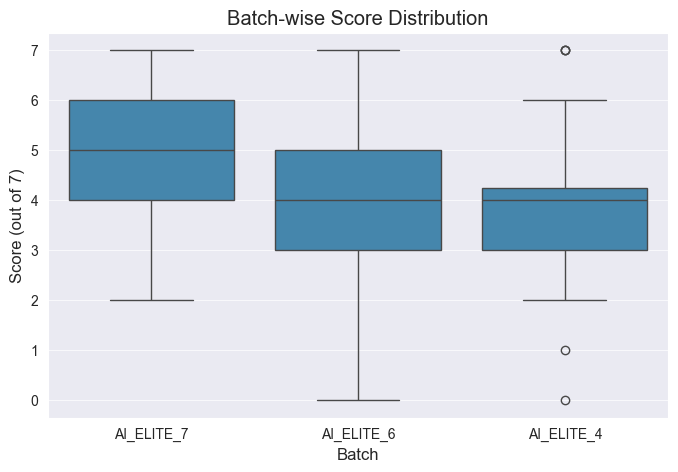

In [32]:
# Boxplot for batch-wise score distribution
plt.figure(figsize=(8,5))
sns.boxplot(x="Batch", y="Score_numeric", data=df)
plt.title("Batch-wise Score Distribution")
plt.ylabel("Score (out of 7)")
plt.xlabel("Batch")
plt.show();


#### Boxplot Observations – Batch-wise Score Distribution

- **AI_ELITE_7** has the highest median score (**5**) and the **narrowest interquartile range (IQR)**, indicating the most consistent high performance.
- **AI_ELITE_6** and **AI_ELITE_4** both have a median score of **4**.
- **AI_ELITE_6** shows a **slightly wider IQR** than AI_ELITE_7, meaning more variability in student scores.
- **AI_ELITE_4** has the **largest spread toward lower scores** and contains several **low-score outliers**.
- **Outliers (low scores)** are present in **AI_ELITE_4** and **AI_ELITE_6**, but are minimal in **AI_ELITE_7**.
- The **upper whisker for AI_ELITE_7 reaches the maximum score (7)**, indicating some students achieved a perfect score.
- Overall, **AI_ELITE_7 demonstrates superior and more consistent performance** compared to the other two batches.

### 12. Percentage-based Score Distribution per Batch

- Batch sizes are unequal, so raw counts can mislead comparisons.
- Percentage-based distributions allow fair comparison across batches.


In [34]:
# Step 1: Count students per batch and score
score_counts = (
    df.groupby(["Batch", "Score_numeric"])
      .size()
      .reset_index(name="Count")
)

score_counts.head()


,Batch,Score_numeric,Count
0,AI_ELITE_4,0,1
1,AI_ELITE_4,1,1
2,AI_ELITE_4,2,7
3,AI_ELITE_4,3,8
4,AI_ELITE_4,4,19


In [35]:
# Step 2: Convert counts to percentages within each batch
score_counts["Percentage"] = (
    score_counts["Count"] /
    score_counts.groupby("Batch")["Count"].transform("sum")
) * 100

score_counts.head()


,Batch,Score_numeric,Count,Percentage
0,AI_ELITE_4,0,1,2.083333
1,AI_ELITE_4,1,1,2.083333
2,AI_ELITE_4,2,7,14.583333
3,AI_ELITE_4,3,8,16.666667
4,AI_ELITE_4,4,19,39.583333


In [36]:
# Step 3: Verify percentages sum to 100 for each batch
score_counts.groupby("Batch")["Percentage"].sum()


Batch
AI_ELITE_4    100.0
AI_ELITE_6    100.0
AI_ELITE_7    100.0
Name: Percentage, dtype: float64

In [37]:
# Step 4: Pivot data for visualization
score_dist_pivot = score_counts.pivot(
    index="Batch",
    columns="Score_numeric",
    values="Percentage"
).fillna(0)

score_dist_pivot


Score_numeric,0,1,2,3,4,5,6,7
Batch,,,,,,,,
AI_ELITE_4,2.083333,2.083333,14.583333,16.666667,39.583333,16.666667,2.083333,6.250000
AI_ELITE_6,2.083333,4.166667,6.250000,18.750000,22.916667,27.083333,8.333333,10.416667
AI_ELITE_7,0.000000,0.000000,3.773585,13.207547,18.867925,20.754717,24.528302,18.867925


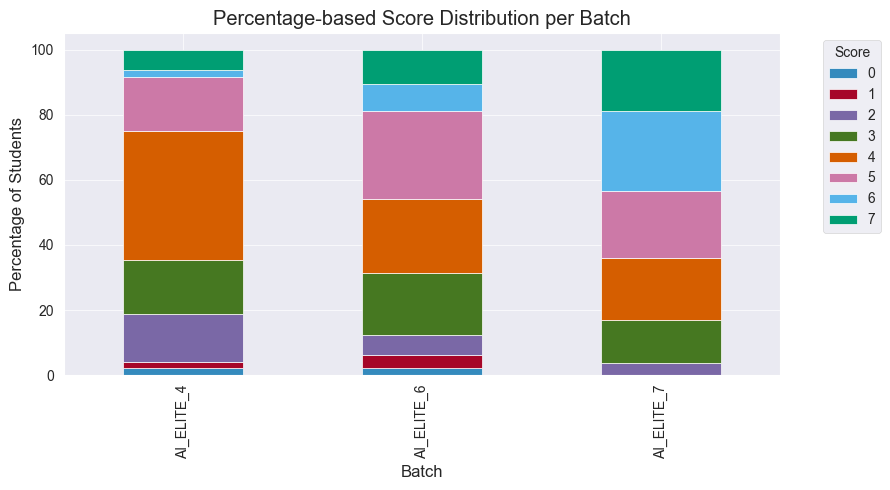

In [39]:
# Step 5: Stacked bar chart for percentage-based distribution
score_dist_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(9,5)
)

plt.title("Percentage-based Score Distribution per Batch")
plt.xlabel("Batch")
plt.ylabel("Percentage of Students")
plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show();


#### Observations – Percentage-based Score Distribution per Batch

- **AI_ELITE_7** has the **highest percentage of top scorers**:  
  - ~24.5% scored a **6**  
  - ~18.9% scored a **7**  
  - **No students scored 0 or 1**

- **AI_ELITE_4** has the **highest concentration in the mid-to-low range**:  
  - ~39.6% of students scored a **4**  
  - Significant percentages scored **2 (14.6%)** and **3 (16.7%)**  
  - Contains **lowest scores (0 and 1)**, though in small proportions (~2% each)

- **AI_ELITE_6** shows the **most balanced distribution** across scores:  
  - Peak at **5 (27.1%)**, followed by **4 (22.9%)** and **3 (18.75%)**  
  - Moderate representation in both **lower (0–2)** and **higher (6–7)** ranges

- **Score 4 is the most common in AI_ELITE_4**, while **AI_ELITE_7 peaks at score 6**, and **AI_ELITE_6 peaks at score 5**.

- The **percentage of students scoring 5 or above** is clearly highest in **AI_ELITE_7 (~64.2%)**, followed by **AI_ELITE_6 (~45.8%)**, and lowest in **AI_ELITE_4 (~25%)**.

### 13. Identifying High and Low Performers

- Converts score distributions into interpretable performance groups.
- Helps quantify how many students are performing at the extremes.


#### Threshold Definition (Fixed for All Batches)

- High performers: Score ≥ 6
- Low performers: Score ≤ 2

These thresholds are chosen because:
- Scores of 6–7 represent strong performance near the maximum.
- Scores of 0–2 represent clear underperformance.
- Thresholds are applied uniformly across all batches.


In [40]:
# Label students as High / Low / Mid performers
df["Performance_Group"] = np.where(
    df["Score_numeric"] >= 6, "High",
    np.where(df["Score_numeric"] <= 2, "Low", "Mid")
)

df[["Batch", "Score_numeric", "Performance_Group"]].head()


,Batch,Score_numeric,Performance_Group
0,AI_ELITE_7,6,High
1,AI_ELITE_7,6,High
2,AI_ELITE_7,7,High
3,AI_ELITE_7,7,High
4,AI_ELITE_7,4,Mid


In [41]:
# Count performance groups per batch
performance_counts = (
    df.groupby(["Batch", "Performance_Group"])
      .size()
      .reset_index(name="Count")
)

performance_counts


,Batch,Performance_Group,Count
0,AI_ELITE_4,High,4
1,AI_ELITE_4,Low,9
2,AI_ELITE_4,Mid,35
3,AI_ELITE_6,High,9
4,AI_ELITE_6,Low,6
5,AI_ELITE_6,Mid,33
6,AI_ELITE_7,High,23
7,AI_ELITE_7,Low,2
8,AI_ELITE_7,Mid,28


In [42]:
# Convert counts to percentages within each batch
performance_counts["Percentage"] = (
    performance_counts["Count"] /
    performance_counts.groupby("Batch")["Count"].transform("sum")
) * 100

performance_counts


,Batch,Performance_Group,Count,Percentage
0,AI_ELITE_4,High,4,8.333333
1,AI_ELITE_4,Low,9,18.750000
2,AI_ELITE_4,Mid,35,72.916667
3,AI_ELITE_6,High,9,18.750000
4,AI_ELITE_6,Low,6,12.500000
5,AI_ELITE_6,Mid,33,68.750000
6,AI_ELITE_7,High,23,43.396226
7,AI_ELITE_7,Low,2,3.773585
8,AI_ELITE_7,Mid,28,52.830189


In [43]:
# Verify totals match batch sizes
performance_counts.groupby("Batch")["Count"].sum()


Batch
AI_ELITE_4    48
AI_ELITE_6    48
AI_ELITE_7    53
Name: Count, dtype: int64

#### Observations – High and Low Performer Analysis

- **AI_ELITE_7** has the highest proportion of high performers:
  - ~43.4% of students scored 6 or above.
  - Low performers are minimal (~3.8%), indicating fewer students at the lower end.

- **AI_ELITE_4** has the highest proportion of low performers:
  - ~18.8% of students scored 2 or below.
  - High performers are limited (~8.3%), with most students clustered in the mid range.

- **AI_ELITE_6** shows a moderate distribution:
  - High performers make up ~18.8%.
  - Low performers account for ~12.5%.
  - The majority (~68.8%) fall into the mid-performance category.

- Across all batches, the mid-performance group dominates, but the proportion of high and low performers varies noticeably by batch.
- The distribution aligns with earlier percentage-based score analysis and does not contradict previous observations.


### 14. Checking Score Consistency Within Batches

- Mean or median alone can hide internal variation.
- Consistency is assessed by how spread out the scores are within each batch.
- This step focuses on variability, not performance level.


In [44]:
# Compute variability measures per batch
batch_variability = df.groupby("Batch")["Score_numeric"].agg(
    mean="mean",
    std="std",
    min="min",
    max="max"
)

batch_variability


,mean,std,min,max
Batch,,,,
AI_ELITE_4,3.791667,1.443376,0,7
AI_ELITE_6,4.229167,1.640441,0,7
AI_ELITE_7,5.056604,1.446682,2,7


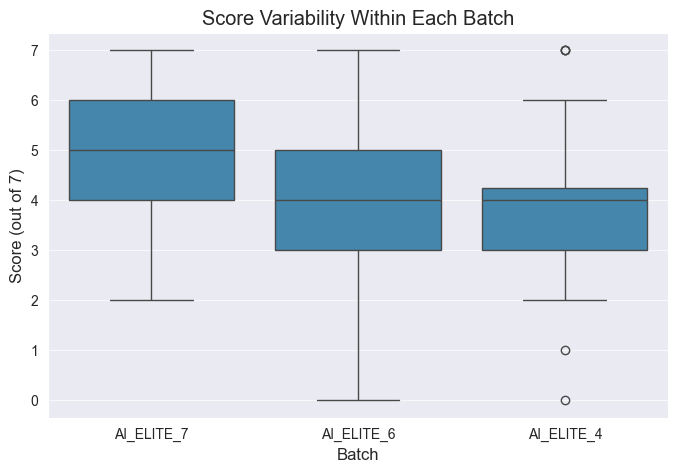

In [45]:
# Boxplot reused specifically to emphasize variability
plt.figure(figsize=(8,5))
sns.boxplot(x="Batch", y="Score_numeric", data=df)
plt.title("Score Variability Within Each Batch")
plt.xlabel("Batch")
plt.ylabel("Score (out of 7)")
plt.show();

#### Observations – Score Variability Within Each Batch

- **Standard Deviation Comparison**:
  - AI_ELITE_6 has the highest standard deviation (1.64), indicating the most dispersed scores.
  - AI_ELITE_4 and AI_ELITE_7 have similar standard deviations (~1.44), showing comparable variability.

- **Score Range per Batch**:
  - All batches share the same maximum score (7).
  - AI_ELITE_4 and AI_ELITE_6 have a minimum score of 0, covering the full possible range (0–7).
  - AI_ELITE_7 has a minimum score of 2, indicating the absence of extremely low scores.

- **Mean and Variability Context**:
  - AI_ELITE_7 combines a higher mean score (5.06) with moderate variability.
  - AI_ELITE_6 shows a lower mean (4.23) with higher variability, reflecting a wider spread of scores.
  - AI_ELITE_4 has the lowest mean (3.79) with moderate variability, while still containing both low and high scores.

- **Boxplot Insight**:
  - AI_ELITE_7 displays a higher median and a tighter interquartile range.
  - AI_ELITE_4 and AI_ELITE_6 show wider interquartile ranges and low-score outliers.


### 15. Overall Dataset Insights (Controlled Conclusions)

- To summarize key patterns observed across all previous analyses.
- To demonstrate reasoning without making unsupported claims.


#### Key Observed Patterns

- Score distributions differ across batches in both central tendency and spread.
- AI_ELITE_7 consistently shows higher central values across mean and median metrics.
- AI_ELITE_4 has a higher concentration of lower scores and a smaller proportion of high scorers.
- AI_ELITE_6 occupies an intermediate position with a more mixed distribution of scores.
- Percentage-based analysis confirms that observed differences are not driven by batch size.
- Variability analysis shows comparable spread across batches, with some differences in dispersion.


#### Limitations

- The dataset contains a limited number of students per batch.
- Scores are bounded within a fixed range (0–7), which constrains variability.
- No information is available about assessment difficulty, grading criteria, or cohort background.
- The analysis is descriptive and does not establish causal relationships.


### 16. Final Conclusion & Submission Readiness

This notebook completes a structured exploratory analysis of student scores across batches.

The work focused on understanding how scores are distributed, how batches differ in performance levels, and how consistent scores are within each batch. All comparisons were done carefully by accounting for batch size differences and avoiding direct use of raw counts where they could mislead.

The analysis was intentionally limited to descriptive and comparative insights. No predictive models or causal assumptions were made, and no batch was labeled as “best” or “worst.” All conclusions are based strictly on the observed data.
